In [17]:
import pickle
# PySpark Imports (MAKE SURE WE PIP INSALL pyspark)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType, DoubleType

# Spark ML Libraries
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Start Spark Session
spark = SparkSession.builder.appName("Diabetes Analysis").getOrCreate()


In [22]:
# Load Data
file_path = "diabetes.csv"  # We may need to change this path in Databricks or Cloudera - I am just doing what I most familiar with right now
df = spark.read.csv(file_path, header=True, inferSchema=True)

# lets see the head and schema
df.printSchema()
df.show(5)

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          

In [23]:
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

# Convert all columns to DoubleType for ML compatibility
for col_name in df.columns:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Basic statistics
df.describe().show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+----------

In [24]:
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                   'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Final DataFrame for modeling
df_scaled.select("scaledFeatures", "Outcome").show(5)

+--------------------+-------+
|      scaledFeatures|Outcome|
+--------------------+-------+
|[1.78063837321943...|    1.0|
|[0.29677306220323...|    0.0|
|[2.37418449762590...|    1.0|
|[0.29677306220323...|    0.0|
|[0.0,4.2849165233...|    1.0|
+--------------------+-------+
only showing top 5 rows



In [25]:
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42) #apparentliy like the sklearn train_test_split
print(f"Training Data Count: {train_df.count()}")
print(f"Test Data Count: {test_df.count()}")

Training Data Count: 645
Test Data Count: 123


In [26]:
# Initialize models
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='Outcome')
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Outcome')
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='Outcome')
dt = DecisionTreeClassifier(featuresCol='scaledFeatures', labelCol='Outcome')

# Train models
lr_model = lr.fit(train_df)
rf_model = rf.fit(train_df)
gbt_model = gbt.fit(train_df)
dt_model = dt.fit(train_df)

In [27]:
# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")

# Evaluate each model
models = {"Logistic Regression": lr_model, "Random Forest": rf_model, 
          "Gradient Boosted Trees": gbt_model, "Decision Tree": dt_model}

for name, model in models.items():
    predictions = model.transform(test_df)
    auc = evaluator.evaluate(predictions)
    print(f"{name} AUC: {auc:.4f}")

Logistic Regression AUC: 0.8619
Random Forest AUC: 0.8578
Gradient Boosted Trees AUC: 0.7939
Decision Tree AUC: 0.7471


In [28]:
# Parameter Grid for Random Forest
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20])\
    .addGrid(rf.maxDepth, [5, 10])\
    .build()

# CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Train with Cross-Validation
cv_model = cv.fit(train_df)
best_rf_model = cv_model.bestModel

# Evaluate the best model
best_rf_predictions = best_rf_model.transform(test_df)
best_auc = evaluator.evaluate(best_rf_predictions)
print(f"Best Random Forest AUC: {best_auc:.4f}")


Best Random Forest AUC: 0.8578


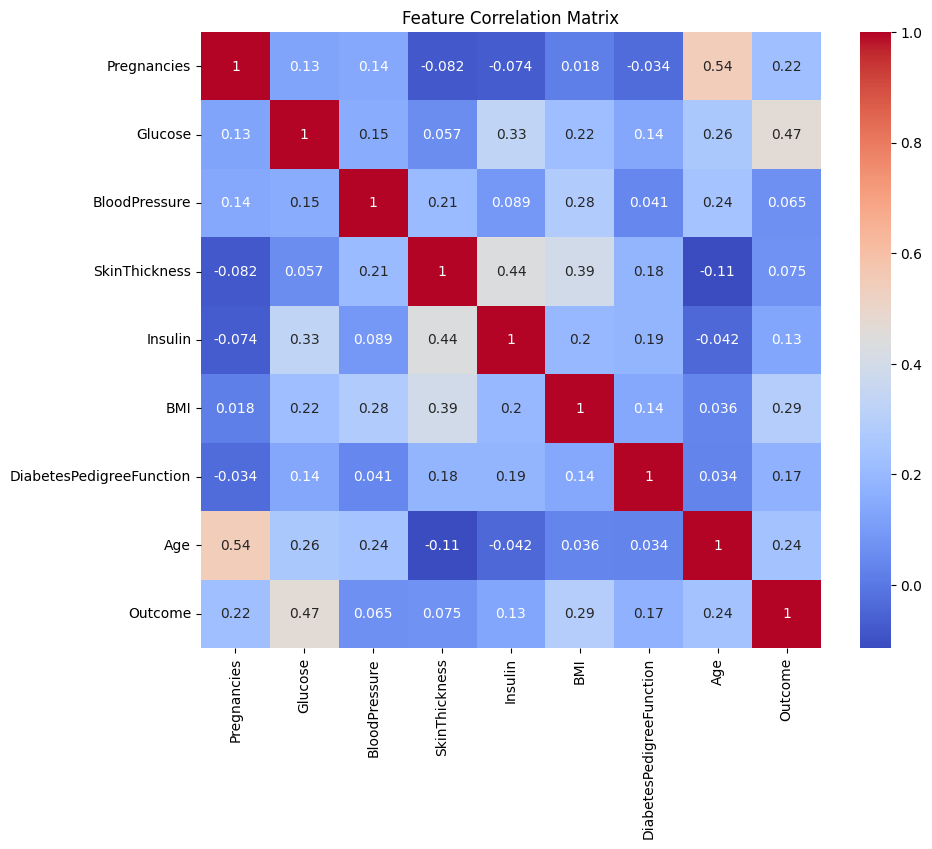

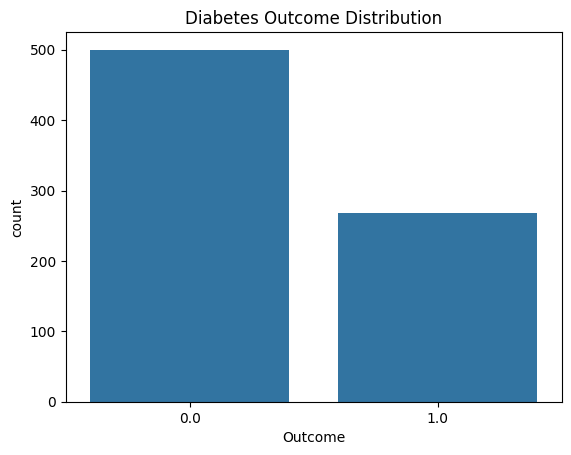

In [29]:
# Convert Spark DataFrame to Pandas for visualization
pandas_df = df.toPandas()

# Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(pandas_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Outcome distribution
sns.countplot(x='Outcome', data=pandas_df)
plt.title("Diabetes Outcome Distribution")
plt.show()


In [31]:
# Save the best model
# best_rf_model.write().overwrite().save("best_random_forest_model")

# with open('best_rf_model.pkl', 'wb') as f:
#     pickle.dump(best_rf_model, f)

# Export predictions to CSV
# best_rf_predictions.select("scaledFeatures", "prediction").toPandas().to_csv("rf_predictions.csv", index=False)
